## Problem 8

In [58]:
import numpy as np
import pandas as pd 
import random
import statistics
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import math

sns.set_style("whitegrid")
random_state=42
import warnings; warnings.simplefilter('ignore')

#### Part 1: data generation
- first I create a function that generates X
- X values are uniformly distributed between 0 and 1 in d dimensions
- the first 2 dimensions are used to assign a label to Y
- I also plot the values of X in relationship to Y, showing that only the first two dimensions of X affect Y, and that the Y values wind up converging to a 50/50 distribution.

In [64]:
def generate_pairs(n,d):
    Xs = np.random.uniform(0,1,size=(n,d))
    X0 = np.array([i[0] for i in Xs])
    X1 = np.array([i[1] for i in Xs])
    Ps = (X1+X0)/2 
    Ys = [1 if p >= 0.5 else 0 for p in Ps]
    mtx = []
    for i in range(n):
        mtx.append(np.append(Xs[i],Ys[i]))

    return mtx

In [74]:
n = 1000
d = 5

data = generate_pairs(n,d)
df = pd.DataFrame(data=data)
df = df.rename(columns={0:'X0',1:'X1',2:'X2',3:'X3',4:'X4',5:'Y'})
df

,X0,X1,X2,X3,X4,Y
0,0.292807,0.683869,0.807956,0.579204,0.379315,0.0
1,0.211805,0.062368,0.290935,0.315483,0.610983,0.0
2,0.106908,0.222292,0.279535,0.363031,0.401733,0.0
3,0.657811,0.849441,0.088188,0.333751,0.473262,1.0
4,0.278042,0.589585,0.889768,0.652670,0.439389,0.0
...,...,...,...,...,...,...
995,0.017243,0.720104,0.254338,0.652505,0.759705,0.0
996,0.938606,0.259671,0.440923,0.365755,0.792749,1.0
997,0.629994,0.204212,0.156810,0.889731,0.673408,0.0
998,0.884549,0.886608,0.138918,0.937496,0.124799,1.0


Text(0.5, 0.98, 'Relationships of different dimensions of X to Y')

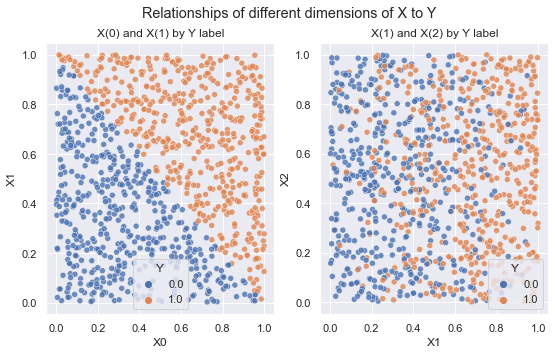

In [81]:
sns.set(rc={'figure.figsize':(9,5)})
fig, ax =plt.subplots(1,2)
a = sns.scatterplot(data=df, x='X0', y='X1', hue='Y',alpha=0.8,ax=ax[0])
b = sns.scatterplot(data=df, x='X1', y='X2', hue='Y',alpha=0.8,ax=ax[1])
a.set_title('X(0) and X(1) by Y label')
b.set_title('X(1) and X(2) by Y label')
fig.suptitle('Relationships of different dimensions of X to Y')


The plot shows that the 0 and 1 labels are distributed with a 50/50 ratio. Adding more dimensions does not affect this.

### Part 2: setting up knn and probability functions
- Next I define functions to find the K nearest neighbors from the training data.
- labels are assigned based on the most common value of the nearest neighbors of the point
- the process is repeated for a large number of test values to generate probability of the estimator assigning correct labels
    - in this case I used 200 repetitions. Less than 200 yielded less smooth graphs, but more than 200 caused computational constraints
 

In [5]:
def find_nn(target,points,k):
    '''
    returns dictionary of nearest neighbor indices based on euclidean distance 
    target: test point
    points: training data
    k: number of neighbors to return
    '''
    distances = {}
    nns = {}
    for i in range(len(points)):
        distances[i] = scipy.spatial.distance.euclidean(target, points[i][:-1])
    while len(nns) < k:
        key = min(distances, key=distances.get)
        nns[key] = distances[key]
        distances.pop(key)
    return nns
    

In [84]:
def assign_label(neighbors,points):
    neighbor_labels = [points[k][-1] for k in neighbors.keys()]
    return statistics.mode(neighbor_labels)
    

In [85]:
def generate_prob(n,d,k):
    '''
    n: size of training data
    d: dimensionality of X
    l: number of neighbors
    '''
    points = generate_pairs(n,d)
    probs = []
    for reps in range(200): # can be changed to higher values for accuracy, lower values for performance
        target_point = generate_pairs(1,d)[0]
        target_point_label = target_point[-1]
        target_point_coords = target_point[:-1]
        nearest_neighbors = find_nn(target_point_coords,points,k)
        assigned_label = assign_label(nearest_neighbors,points)
        p = 0
        if assigned_label == target_point_label:
            p = 1
        probs.append(p)
    return scipy.mean(probs)

In [88]:
# demonstration of KNN functions on 1 test point

target_point = generate_pairs(1,d)[0]
target_point_label = target_point[-1]
target_point_coords = target_point[:-1]
nearest_neighbors = find_nn(target_point_coords,data,3)
assigned_label = assign_label(nearest_neighbors,data)

print(f'Real label: {target_point_label}\nAssigned label: {assigned_label}')

Real label: 1.0
Assigned label: 1.0


### Part 4: Determining risks
- I set up a function to calculate eta(x), or posterior probability 
    - this is given in the problem set-up, it is the probability by which Y is assigned a label
- Using the same definitions as in problem 5, I calculate the risk values for Bayes Risk, Asymptotic Risk of 1-NN, and Asymptotic Risk of 3-NN

In [89]:
def getEta(n,d):
    Xs = np.random.uniform(0,1,size=(n,d))
    X0 = np.array([i[0] for i in Xs])
    X1 = np.array([i[1] for i in Xs])
    Ps = (X1+X0)/2 
    return statistics.mean(Ps)

In [95]:
'''
eta(x) = P{Y = 1|X = x}
R* = Emin(eta(x), 1-eta(x))
R1 = 2R*(1-R*)
Rk = R* + 1/sqrt(ke)
'''

n = 10000
d = 5
eta = getEta(n,d)
risk = min(eta,(1-eta))
risk_1nn = 2*risk*(1-risk)
risk_3nn = risk + 1/math.sqrt(3*math.e)
risk_9nn = risk + 1/math.sqrt(9*math.e)


print(f'eta/posterior probability is {round(eta,4)}')
print(f'bayes risk is {round(risk,4)}')
print(f'1NN risk is {round(risk_1nn,4)}')
print(f'3NN risk is {round(risk_3nn,4)}')
print(f'9NN risk is {round(risk_9nn,4)}')

eta/posterior probability is 0.498
bayes risk is 0.498
1NN risk is 0.5
3NN risk is 0.8481
9NN risk is 0.7001


I don't think the KNN risks are correct, but this is what I get with the current formula.

In [96]:
# demonstration of probability function

n = 5000
d = 5
k = 3
p = generate_prob(n,d,k)


In [99]:
print(f'For {d}-dimensional data with {k} nearest neighbors among {n}\
 points, the target points are labeled correctly with a probability of {round(p,2)}')


For 5-dimensional data with 3 nearest neighbors among 5000 points, the target points are labeled correctly with a probability of 0.93


### Part 5: plotting relationships across ranges of n, d, and k
- Below I define functions that generate a range of probabilities of test points being labeled correctly for a set of k values across a range of dimensions and training sample sizes
- I plot the relationships to show any trends
    - I used both continuous ranges and interval ranges to show trends at different scales
    - The points were scattered and hard to visualize in some cases, so I used Seaborns' "lmplot" graph to show trend lines clearly
- because the calculations in a loop are so computationally expensive, I split up the visualization into parts. I show the relationships at low values of n, and at high values (with intervals).

In [11]:
def explore_n_k(n_range,d):
    '''
    n_range: range of training data sample size
    d: dimensionality of X
    '''
    ks = [1, 3, 5, 7, 9]
    probs = [generate_prob(n,d,k) for k in ks for n in n_range]
    k_val = [k for k in ks for x in n_range]
    n_val = [x for k in ks for x in n_range]
    print('values generated')
    
    df = pd.DataFrame(list(zip(probs, k_val, n_val)), 
               columns =['prob', 'k', 'n'])
    
    return df

In [20]:
def explore_d_k(n,d_range):
    '''
    n: training data sample size
    d: range of dimensions of X
    '''
    ks = [1, 3, 5, 7, 9]
    probs = [generate_prob(n,d,k) for k in ks for d in d_range]
    k_val = [k for k in ks for x in d_range]
    d_val = [x for k in ks for x in d_range]
    print('values generated')
    
    df = pd.DataFrame(list(zip(probs, k_val, d_val)), 
               columns =['prob', 'k', 'd'])
    
    return df

In [12]:
# first, try a small, continuous range of n

ns = range(100,200)
d = 5
small_prob_df = explore_n_k(ns,d)


values generated


Text(0.5, 1.0, 'KNN performance over increasing n - small values')

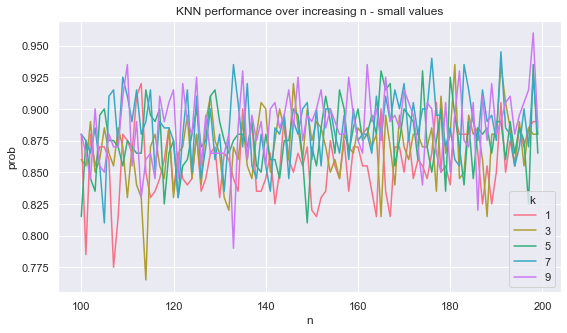

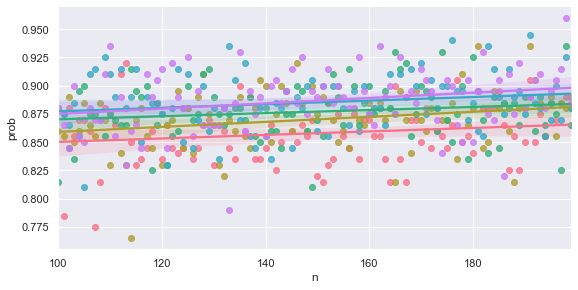

In [114]:
sns.set(rc={'figure.figsize':(9,5)})
p = sns.color_palette("husl", 5)

a = sns.lineplot(data=small_prob_df, y='prob',x='n',hue='k',palette=p)
b = sns.lmplot(data=small_prob_df, y='prob',x='n',hue='k',palette=p,\
               height=4, aspect=2,legend=False)

a.set_title('KNN performance over increasing n - small values')


The trends are not very clear here. I can see that the estimator becomes more accurate at higher n. From the regression plot, I also see that more neighbors increases the accuracy, but this patterns is not as visually apparent.

In [14]:
ns = range(500,2000,200)
d = 5
big_prob_df = explore_n_k(ns,d)

values generated


Text(0.5, 1.0, 'KNN performance over increasing n - large values')

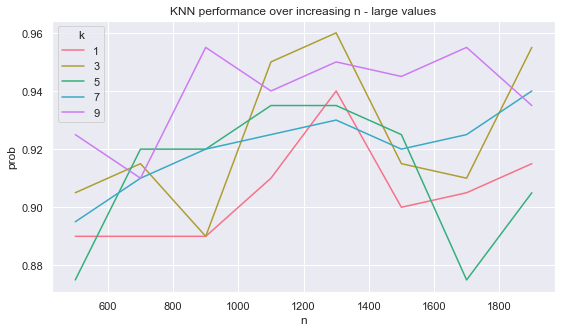

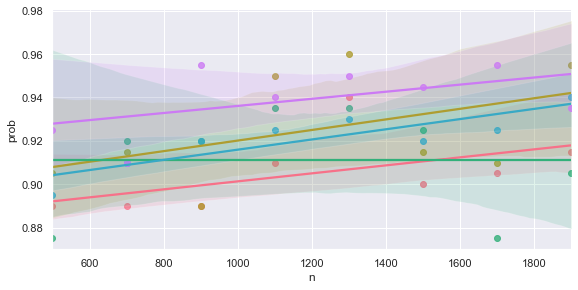

In [116]:
a = sns.lineplot(data=big_prob_df, y='prob',x='n',hue='k',palette=p)
b = sns.lmplot(data=big_prob_df, y='prob',x='n',hue='k',palette=p,\
               height=4, aspect=2,legend=False)

a.set_title('KNN performance over increasing n - large values')


At higher values of n, higher k continue to perform better than lower k, with the exception of the 5NN estimator. There would be a clearer pattern with more data points. I expect the risk to converge towards 0 as n converges to infinity. There should be a ratio at which more neighbors no longer increases performance.

In [119]:
ds = range(2,60)
n = 500
diff_d_prob_df = explore_d_k(n,ds)

values generated


Text(0.5, 1.0, 'KNN performance over increasing dimensions of X')

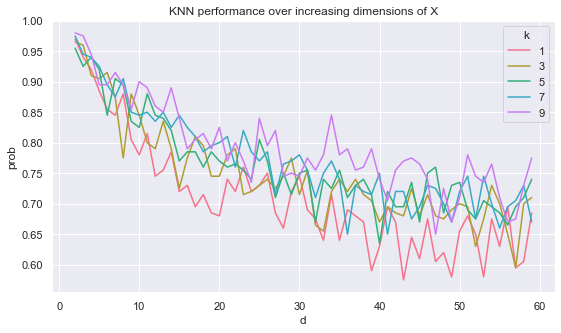

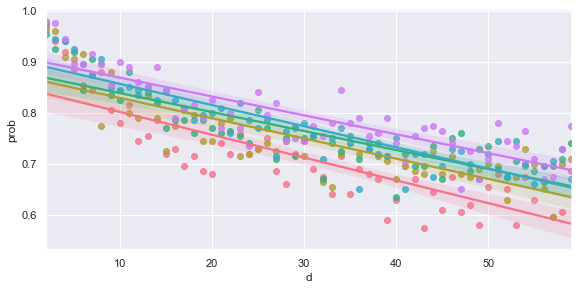

In [120]:
a = sns.lineplot(data=diff_d_prob_df, y='prob',x='d',hue='k',palette=p)
b = sns.lmplot(data=diff_d_prob_df, y='prob',x='d',hue='k',palette=p,\
               height=4, aspect=2,legend=False)

a.set_title('KNN performance over increasing dimensions of X')


In [133]:
converge_d_1nn = generate_prob(500,100000,1)
converge_d_9nn = generate_prob(500,100000,9)

In [134]:
converge_d_1nn, converge_d_9nn

(0.495, 0.525)

Performance decreases with higher dimensions of X. This makes sense because only the first two dimensions of X affect the Y label, so adding more dimensions simply increases the noise of the training data. The higher k estimators' performance decreases less rapidly with increased dimensionality when compared to lower k. From visual inspection, it appears that as d increases to infinity, the risk would converge to 0.5. I confirmed this by calculating individual probabilities at very high dimensions for 1- and 9- nearest neighbors.Below is a graph of individual probabilities for 1- and 9- NN. It appears that the real value is a bit below 0.5.


In [142]:
c1nn = []
c9nn = []
ds = []
for d in range(2,1000,10):
    c1nn.append(generate_prob(500,d,1))
    c9nn.append(generate_prob(500,d,9))
    ds.append(d)

Text(0.5, 1.0, 'Risk for 1- and 9- NN models over increasing dimensionality')

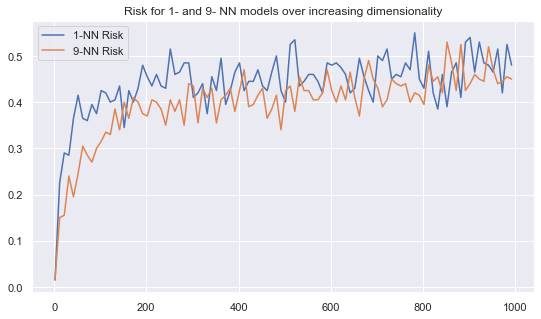

In [145]:
df = pd.DataFrame({'1-NN Risk': [1-x for x in c1nn],
                   '9-NN Risk': [1-x for x in c9nn]},
                  index=ds)

lines = df.plot.line()
lines.set_title('Risk for 1- and 9- NN models over increasing dimensionality')
